In [1]:
import torch
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from pathlib import Path
from random import sample
from functools import partial
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR, SVR
from hyperopt import STATUS_OK, fmin, tpe, hp
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from transformers import ConvNextImageProcessor, ConvNextForImageClassification, AutoImageProcessor, AutoModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

c:\Users\fmore\anaconda3\envs\envnestedai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator, TransformerMixin

class Transformer(ABC, BaseEstimator, TransformerMixin):

    @abstractmethod
    def __init__(self):
        super().__init__()

    @abstractmethod
    def fit(self, X: pd.DataFrame, y=None):
        pass

    @abstractmethod
    def transform(self, X: pd.DataFrame):
        pass

class Nothing(Transformer):
    def __init__(self):
        # TODO
        pass

    def fit(self, X, y=None):

        # TODO

        return self

    def transform(self, X):

        # TODO

        return X

# Text ONLY

In [ ]:
txt_dataset_path = Path("./data/global_df.csv")

## Preparation

In [ ]:
df = pd.read_csv(txt_dataset_path, index_col=0)

In [ ]:
cols_to_keep = ["Number of Bedrooms", "Number of bathrooms", "Area", "density", "population", "city", "Price"]
df = df[cols_to_keep]

In [ ]:
target = "Price"

X = df.drop(columns=[target])
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
# max_price = y.max()
# y_train = y_train/max_price
# y_test = y_test/max_price

In [ ]:
encoded_var = ["city"]
numerical_var = X.columns.drop(encoded_var)

In [ ]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

## Model Training

### SVR

In [ ]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", SVR())
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

### Random forest

In [ ]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", RandomForestRegressor())
])

In [ ]:
parameters = {
    "transformer__cat__max_categories": [4, 8, 11, 14],
    "estimator__max_depth": [None, 3, 5, 7],
    "estimator__n_estimators": [50, 100, 150, 200],
    "estimator__criterion": ['squared_error', 'absolute_error']
}

grid = GridSearchCV(pipeline, parameters, verbose=1)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)*max_price**2}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)*max_price}")

In [ ]:
# Feature importance
dict(
    sorted(
        zip(
            pipeline[0].get_feature_names_out(),
            pipeline[-1].feature_importances_
        ),
    key=lambda x: x[1],
    reverse=True)
)

### LinearSVR

In [ ]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", LinearSVR())
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

### xgBoost

#### No hyperparameters tuning

In [ ]:
data_pipeline = Pipeline([
    ('transform', transformer)
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.01,
    'n_estimators': 1000,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

#### Hyperparameters Tuning

In [ ]:
data_pipeline = Pipeline([
    ('transform', transformer)
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

In [ ]:
# Define the hyperparameter space
search_space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 10e1),
    'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
    'reg_lambda' : hp.uniform("reg_lambda", 0,1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
    'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
    'max_delta_step' : hp.choice("max_delta_step", np.arange(1,10,1,dtype='int')),
    'subsample' : hp.uniform("subsample",0.5,1),
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
    'seed' : 44
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train_processed, y_train)
    y_pred = xgb_model.predict(X_test_processed)
    score = mean_squared_error(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, search_space, algo=tpe.suggest, max_evals=200)
print("Best set of hyperparameters: ", best_params)

In [ ]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)

print(f"MSE : {(mean_squared_error(y_test, y_pred)*(max_price**2)*1e-9).round(6)}*10^9")
print(f"MAE : {mean_absolute_error(y_test, y_pred)*max_price}")
print(f"R2 : {r2_score(y_test, y_pred)}")

# Image ONLY

In [ ]:
txt_dataset_path = Path("./data/global_df.csv")
img_features_dataset_path = Path("./data/img_features_dataset_dinoV2_small.csv")

## Preparation

In [ ]:
txt_dataset = pd.read_csv(txt_dataset_path)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

img_features_dataset.index = [int(idx.replace("_house", ""))-1 for idx in img_features_dataset.index]


df = pd.merge(txt_dataset[["Price"]], img_features_dataset, left_index=True, right_index=True)

In [ ]:
correlations = df.corr()['Price'].abs()
sorted_features = correlations.sort_values(ascending=False)
important_features = sorted_features[:16].drop('Price')
important_features

In [ ]:
target = "Price"

X = df[important_features.index]
y = df[[target]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data_pipeline = Pipeline([
    ('standardization', StandardScaler()),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

## Model Training

In [ ]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.001,
    'n_estimators': 2000,
    'gamma': 1e-2,
    'max_depth': 2,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)

In [ ]:
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

In [ ]:
bst.get_booster().get_score(importance_type='weight')

# Text + Image (Augmented dataset)

In [ ]:
txt_dataset_path = Path("./data/global_df_augm.csv")
img_features_dataset_path = Path("./data/img_IMPORTANT_features_augm_dataset_dinoV2_small.csv")

## Preparation

In [ ]:
txt_dataset = pd.read_csv(txt_dataset_path, index_col='ID_augm')
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

df = pd.merge(txt_dataset, img_features_dataset, left_index=True, right_index=True)

In [ ]:
test_size = int(df.shape[0]//2 * 0.2)
test_ids = sample(range(1, df.shape[0]//2 + 1), test_size)
test_ids = [str(idx) + "_1" for idx in test_ids] + [str(idx) + "_2" for idx in test_ids]

In [ ]:
target = "Price"

X = df.drop(columns=[target])
y = df[target]

X_train = X[~X.index.isin(test_ids)]
y_train = y[~y.index.isin(test_ids)]

X_test = X[X.index.isin(test_ids)]
y_test = y[y.index.isin(test_ids)]

In [ ]:
encoded_var = ["city"]
img_features = [col for col in X.columns if col.startswith("feature_")]
numerical_var = X.columns.drop(encoded_var + img_features).to_list()

In [ ]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=5, handle_unknown='infrequent_if_exist'), encoded_var),
    ("img_features", Nothing(), img_features),
])

## Model Training

In [ ]:
data_pipeline = Pipeline([
    ('transform', transformer),
    ('pca', PCA(n_components=10))
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.005,
    'n_estimators': 3000,
    'max_depth': 6
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

# Text + Image (simple dataset)

In [ ]:
txt_dataset_path = Path("./data/global_df.csv")
img_features_dataset_path = Path("./data/img_IMPORTANT_features_dataset_resnet50.csv")

## Preparation

In [ ]:
txt_dataset = pd.read_csv(txt_dataset_path)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

# img_features_dataset.index = [int(idx.replace("_house", ""))-1 for idx in img_features_dataset.index]

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

nb_img_features_to_keep = 10
img_features_dataset = img_features_dataset.iloc[:, :nb_img_features_to_keep]

df = pd.merge(txt_dataset, img_features_dataset, left_index=True, right_index=True)

In [ ]:
target = "Price"

X = df.drop(columns=target)
y = df[[target]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# max_price = y.max().item()
# y_train = y_train/max_price
# y_test = y_test/max_price

In [ ]:
encoded_var = ["city"]
img_features = img_features_dataset.columns.to_list()
numerical_var = X.columns.drop(encoded_var + img_features).to_list()

In [ ]:
class PartialPCA(Transformer):
    def __init__(self, columns: list[str], n_components: int):
        self.columns = columns
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.pca_features = [f"pca_{i}" for i in range(self.n_components)]

    def fit(self, X, y=None):

        self.pca.fit(X[self.columns])

        return self
    
    def transform(self, X):

        X_pca_array = self.pca.transform(X[self.columns])
        X_pca_df = pd.DataFrame(X_pca_array, columns=self.pca_features, index=X.index)

        cols_to_drop = [col for col in X.columns if col.startswith("feature_")]

        X = pd.merge(X.drop(columns=cols_to_drop), X_pca_df, left_index=True, right_index=True)

        return X

In [ ]:
pca_n_components = 5
pca_features = [f"pca_{i}" for i in range(pca_n_components)]

transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var + img_features),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

data_pipeline = Pipeline([
    # ('pca_img_features', PartialPCA(columns=img_features, n_components=pca_n_components)),
    ('transform', transformer),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

## Model Training

#### Random Foret

In [ ]:
pipeline = Pipeline([
    ("data_pipeline", data_pipeline),
    ("estimator", RandomForestRegressor())
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

### XGbosst

#### Without Hyperparameters tuning

In [ ]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'max_depth': 2,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)

In [ ]:
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

In [ ]:
bst.get_booster().get_score(importance_type='weight')

#### Hyperparameters Tuning

In [ ]:
def objective(X_train_, X_test_, y_train_, y_test_, trial):
    
    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        'eval_metric' : 'rmse',
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        'eta'      : trial.suggest_float("eta", 0, 1),
        'gamma'    : trial.suggest_float("gamma", 0, 15e1),
        'reg_alpha': trial.suggest_float("reg_alpha", 10e-7, 10),
        'reg_lambda' : trial.suggest_float("reg_lambda", 0,1),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_, y_train_, verbose=False)
    predictions = model.predict(X_test_)
    rmse = root_mean_squared_error(y_test_, predictions)
    
    return rmse


partial_objective = partial(objective, X_train_processed, X_test_processed, y_train, y_test)

In [ ]:
study = optuna.create_study(
    direction='minimize',
)

study.optimize(partial_objective, n_trials=500)

In [ ]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

params = study.best_params | {
    "objective": "reg:squarederror",
    'eval_metric' : 'rmse',
}

model = xgb.XGBRegressor(**params)
model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

y_test_pred = model.predict(X_test_processed)

In [ ]:
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R2 : {r2_score(y_test, y_test_pred)}")

In [ ]:
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

# Text + Image X4 (simple dataset)

Previously, images features are extracted from each image separatly, and then concatenated in a single vector

In [3]:
txt_dataset_path = Path("./data/global_df.csv")
img_features_dataset_path = Path("./data/img_x4_features_dataset_dinoV2_small.csv")

## Preparation

In [4]:
txt_dataset = pd.read_csv(txt_dataset_path)
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

img_features_dataset.index = [int(idx.replace("_house", ""))-1 for idx in img_features_dataset.index]

In [ ]:
n_components=10
tsne = TSNE(n_components=n_components, method="exact")
img_features_tsne = tsne.fit_transform(img_features_dataset)

img_features_tsne_df = pd.DataFrame(img_features_tsne)
img_features_tsne_df.columns = ["tsne_img_feature_" + str(col) for col in img_features_tsne_df.columns]

In [ ]:
df = pd.merge(txt_dataset, img_features_tsne_df, left_index=True, right_index=True)

In [7]:
target = "Price"

X = df.drop(columns=target)
y = df[[target]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# max_price = y.max().item()
# y_train = y_train/max_price
# y_test = y_test/max_price

In [ ]:
encoded_var = ["city"]
img_features = img_features_tsne_df.columns.to_list()
numerical_var = X.columns.drop(encoded_var + img_features).to_list()

In [15]:
class PartialTSNE(Transformer):
    def __init__(self, columns: list[str], n_components: int):
        self.columns = columns
        self.n_components = n_components
        self.tsne = TSNE(n_components=self.n_components)
        self.tsne_features = [f"tsne_{i}" for i in range(self.n_components)]

    def fit(self, X, y=None):

        self.tsne.fit(X[self.columns])

        return self
    
    def transform(self, X):

        X_tsne_array = self.tsne.transform(X[self.columns])
        X_tsne_df = pd.DataFrame(X_tsne_array, columns=self.tsne_features, index=X.index)

        cols_to_drop = [col for col in X.columns if col.startswith("feature_")]

        X = pd.merge(X.drop(columns=cols_to_drop), X_tsne_df, left_index=True, right_index=True)

        return X

In [ ]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var + img_features),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

data_pipeline = Pipeline([
    # ('tsne_img_features', PartialTSNE(columns=img_features, n_components=tsne_n_components)),
    ('transform', transformer),
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

pd.DataFrame(X_train_processed).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,4.280000e+02,4.280000e+02,4.280000e+02,4.280000e+02,4.280000e+02,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,-2.178942e-16,1.203606e-16,4.980440e-17,2.490220e-17,-1.079095e-16,0.107477,0.074766,0.056075,0.035047,0.091121,0.023364,0.049065,0.021028,0.098131,0.028037,0.051402,0.023364,0.200935,0.140187
std,1.001170e+00,1.001170e+00,1.001170e+00,1.001170e+00,1.001170e+00,0.310081,0.263322,0.230335,0.184113,0.288119,0.151235,0.216257,0.143646,0.297840,0.165273,0.221074,0.151235,0.401168,0.347587
min,-2.060788e+00,-1.670366e+00,-1.345339e+00,-1.221751e+00,-6.718905e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.211090e-01,-6.602402e-01,-7.467527e-01,-9.366290e-01,-6.397178e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.211090e-01,-1.551771e-01,-2.392910e-01,-5.232572e-01,-5.906473e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.487306e-01,3.498860e-01,5.617938e-01,5.593510e-01,3.725283e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.767769e+00,4.390391e+00,5.849035e+00,2.733805e+00,5.983654e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Models

### XGBoost

In [12]:
def objective(X_train_, X_test_, y_train_, y_test_, trial):
    
    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        'eval_metric' : 'rmse',
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        'eta'      : trial.suggest_float("eta", 0, 1),
        'gamma'    : trial.suggest_float("gamma", 0, 15e1),
        'reg_alpha': trial.suggest_float("reg_alpha", 10e-7, 10),
        'reg_lambda' : trial.suggest_float("reg_lambda", 0,1),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_, y_train_, verbose=False)
    predictions = model.predict(X_test_)
    rmse = root_mean_squared_error(y_test_, predictions)
    
    return rmse


partial_objective = partial(objective, X_train_processed, X_test_processed, y_train, y_test)

In [13]:
study = optuna.create_study(
    direction='minimize',
)

study.optimize(partial_objective, n_trials=200)

[I 2024-12-09 23:00:58,860] A new study created in memory with name: no-name-939478cc-2e47-4dac-9a0b-c93d1c74a177
[I 2024-12-09 23:00:59,034] Trial 0 finished with value: 341314.647293897 and parameters: {'n_estimators': 271, 'learning_rate': 0.0006598139040041798, 'max_depth': 5, 'subsample': 0.6731569081447962, 'colsample_bytree': 0.9100540562793124, 'min_child_weight': 20, 'eta': 0.16921075739952451, 'gamma': 55.64631751974184, 'reg_alpha': 6.728538956145532, 'reg_lambda': 0.7102358886611563}. Best is trial 0 with value: 341314.647293897.
[I 2024-12-09 23:00:59,423] Trial 1 finished with value: 273623.2243489363 and parameters: {'n_estimators': 1817, 'learning_rate': 0.06467283711819638, 'max_depth': 3, 'subsample': 0.21537037280801063, 'colsample_bytree': 0.1433882543569006, 'min_child_weight': 7, 'eta': 0.5427250969634212, 'gamma': 6.787384415960496, 'reg_alpha': 0.1453076010253519, 'reg_lambda': 0.5058334817567736}. Best is trial 1 with value: 273623.2243489363.
[I 2024-12-09 23:

In [14]:
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

params = study.best_params | {
    "objective": "reg:squarederror",
    'eval_metric' : 'rmse',
}

model = xgb.XGBRegressor(**params)
model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

y_test_pred = model.predict(X_test_processed)

[0]	validation_0-rmse:532393.99700	validation_1-rmse:371168.36140
[1]	validation_0-rmse:528764.95297	validation_1-rmse:367120.85268
[2]	validation_0-rmse:524405.30087	validation_1-rmse:364063.53686
[3]	validation_0-rmse:518337.15652	validation_1-rmse:358665.92327
[4]	validation_0-rmse:514907.95057	validation_1-rmse:355591.28316
[5]	validation_0-rmse:509146.29216	validation_1-rmse:350595.18111
[6]	validation_0-rmse:503764.16359	validation_1-rmse:345485.17890
[7]	validation_0-rmse:499005.18614	validation_1-rmse:340815.42157
[8]	validation_0-rmse:495809.97771	validation_1-rmse:338305.59123
[9]	validation_0-rmse:490509.92118	validation_1-rmse:334413.77574
[10]	validation_0-rmse:484850.18203	validation_1-rmse:329736.82340
[11]	validation_0-rmse:481585.60754	validation_1-rmse:326987.25095


[12]	validation_0-rmse:476300.37712	validation_1-rmse:322583.54462
[13]	validation_0-rmse:473387.01193	validation_1-rmse:318922.44705
[14]	validation_0-rmse:469600.82413	validation_1-rmse:315507.40666
[15]	validation_0-rmse:465246.23260	validation_1-rmse:311130.70203
[16]	validation_0-rmse:460867.28911	validation_1-rmse:307565.75670
[17]	validation_0-rmse:456690.72510	validation_1-rmse:303832.26522
[18]	validation_0-rmse:453919.73434	validation_1-rmse:301555.77939
[19]	validation_0-rmse:450227.36712	validation_1-rmse:298551.62130
[20]	validation_0-rmse:446039.60595	validation_1-rmse:295514.31118
[21]	validation_0-rmse:444187.08468	validation_1-rmse:294240.59583
[22]	validation_0-rmse:440259.44619	validation_1-rmse:290855.00737
[23]	validation_0-rmse:436234.65953	validation_1-rmse:288053.75656
[24]	validation_0-rmse:433912.63166	validation_1-rmse:286025.33061
[25]	validation_0-rmse:430951.17660	validation_1-rmse:283110.07182
[26]	validation_0-rmse:427884.50528	validation_1-rmse:280567.3

In [15]:
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R2 : {r2_score(y_test, y_test_pred)}")

MSE : 33988697283.1759
MAE : 121655.24704293224
R2 : 0.7545254230499268


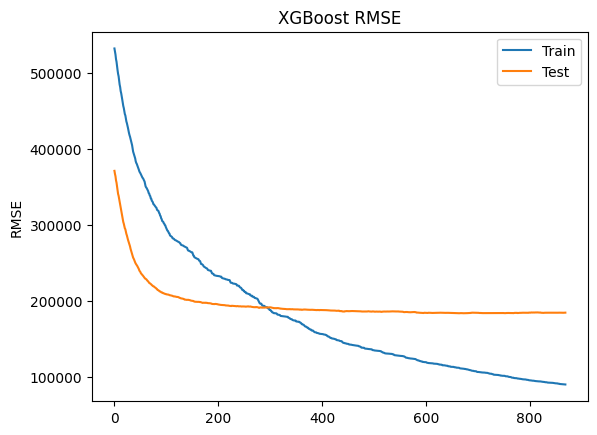

In [16]:
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

### Neural Network torch

In [ ]:
lr = 0.001
momentum = 0.9
batch_size = 5
nb_epoch = 2000

In [ ]:
X_train_torch = torch.from_numpy(X_train_processed).float()
y_train_torch = torch.from_numpy(y_train.to_numpy()).float()
y_train_torch = y_train_torch.view(len(y_train), 1)

In [ ]:
trainloader = torch.utils.data.DataLoader(X_train_processed, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(X_test_processed, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size: int):
        super(Net, self).__init__()

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(input_size, 128)

        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):

        x = self.dropout1(x)
        x = F.relu(self.fc1(x))

        x = self.dropout2(x)
        x = F.relu(self.fc2(x))

        output = self.fc3(x)

        return output

model = Net(input_size=X_train_processed.shape[1])
print(model)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
loss_l = []
for num_epoch in range(nb_epoch):

    y_train_pred = model(X_train_torch)
    loss = criterion(y_train_pred, y_train_torch)

    model.zero_grad()
    loss.backward()
    optimizer.step()


    loss_l.append(loss.item())
    if num_epoch % 1 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

### Neural Network sklearn

In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=(X_train_processed.shape[1], 10, 1),
    learning_rate="adaptive",
    learning_rate_init=0.001,   
)

pipeline = Pipeline([
    ('data_pipeline', data_pipeline),
    ('MLP', mlp),
])

In [ ]:
pipeline.fit(X_train, y_train.values.ravel())

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"R2 : {r2_score(y_test, y_pred)}")

In [ ]:
pipeline[-1].validation_scores_

In [ ]:
plt.plot(pipeline[-1].loss_curve_)
plt.show()